In [1]:
pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade certifi


Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import sklearn
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt



In [5]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
polish_companies_bankruptcy = fetch_ucirepo(id=365) 

# data (as pandas dataframes) 
X = polish_companies_bankruptcy.data.features 
y = polish_companies_bankruptcy.data.targets 

# metadata 
print(polish_companies_bankruptcy.metadata) 
  
# variable information 
print(polish_companies_bankruptcy.variables) 


{'uci_id': 365, 'name': 'Polish Companies Bankruptcy', 'repository_url': 'https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data', 'data_url': 'https://archive.ics.uci.edu/static/public/365/data.csv', 'abstract': 'The dataset is about bankruptcy prediction of Polish companies.The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 10503, 'num_features': 65, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2016, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5F600', 'creators': ['Sebastian Tomczak'], 'intro_paper': {'title': 'Ensemble boosted trees with synthetic features generation in application to bankruptcy prediction', 'authors': 'Maciej Ziȩba,

In [6]:
df = pd.concat([X, y], axis=1)
df = df.dropna()
X = df.drop('class', axis=1)
y = df["class"]
X_train = X[X['year'].isin([1, 2, 3, 4])]
X_test = X[X['year']==5]
y_train = y.iloc[:len(X_train)]
y_test = y.tail(len(X_test))

In [7]:
from sklearn.ensemble import RandomForestRegressor as RF

In [9]:
bag_polish = RF(max_features=X_train.shape[1], 
                random_state=0)
bag_polish.fit(X_train, y_train)

RandomForestRegressor(max_features=65, random_state=0)

0.020342923127680636

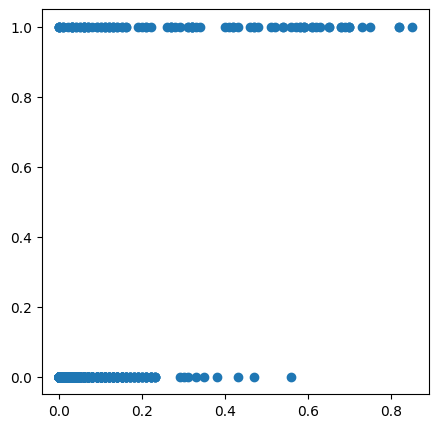

In [14]:
ax = subplots(figsize=(5,5))[1] 
y_hat_bag = bag_polish.predict(X_test) 
ax.scatter(y_hat_bag, y_test) 
np.mean((y_test - y_hat_bag)**2)

In [16]:
bag_polish = RF(max_features=X_train.shape[1], 
                n_estimators=500,
                random_state=0).fit(X_train, y_train) 

y_hat_bag = bag_polish.predict(X_test)
np.mean((y_test - y_hat_bag)**2)
#not much change

0.020086503464203233

In [56]:
feature_names = X_train.columns
feature_imp = pd.DataFrame({'importance':bag_polish.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False).head(8)

,importance
A24,0.047636
A46,0.046624
A58,0.041193
A5,0.040817
A34,0.040738
A39,0.034354
A56,0.029402
A26,0.026688


In [51]:
from sklearn.tree import DecisionTreeRegressor as DTR
from matplotlib.pyplot import subplots
from sklearn.tree import plot_tree
import sklearn.model_selection as skm
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier as GBC



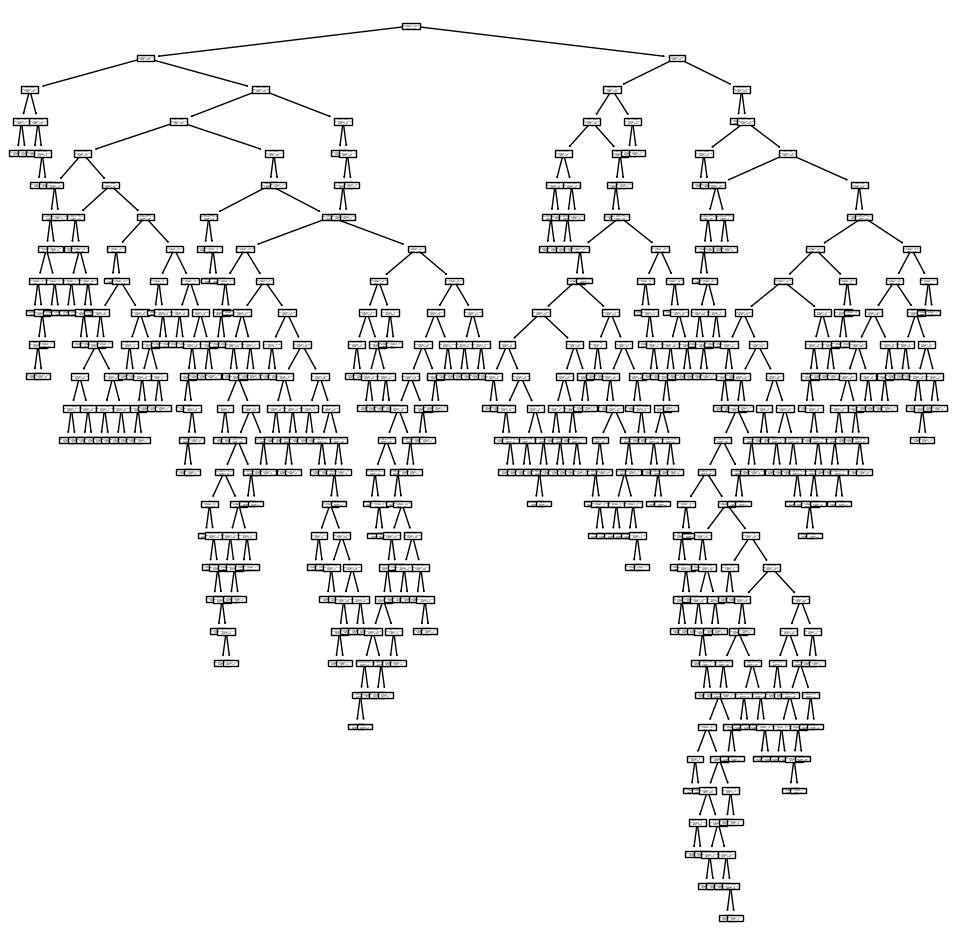

In [20]:
ax = subplots(figsize=(12,12))[1] 
reg = DTR()
reg.fit(X_train, y_train)
plot_tree(reg, 
          feature_names=feature_names, 
          ax=ax);

In [60]:
n_estimators = 100
learning_rates = np.arange(0.01, 0.1, 0.02)
num_depths = np.arange(1, 6,2)

param_grid = {'n_estimators': [n_estimators],
              'learning_rate': learning_rates,
              'max_depth': num_depths
             }

boost = GBC(random_state=0)

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=0) 

grid = skm.GridSearchCV(boost,
                        param_grid,
                        refit=True,
                        cv=kfold, 
                        scoring='f1')

G = grid.fit(X_train, y_train)


best_clf = grid.best_estimator_
test_f1= f1_score(y_test, best_clf.predict(X_test))

print("Best parameters:", best_clf)
print("Test F1 Score with best parameters:", test_f1)

Best parameters: GradientBoostingClassifier(learning_rate=0.08999999999999998, max_depth=5,
                           random_state=0)
Test F1 Score with best parameters: 0.4172661870503597


In [61]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(X_test)
recall = recall_score(y_test, y_pred)
print("Recall rate:", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Recall rate: 0.28431372549019607
Accuracy: 0.9732761464863081


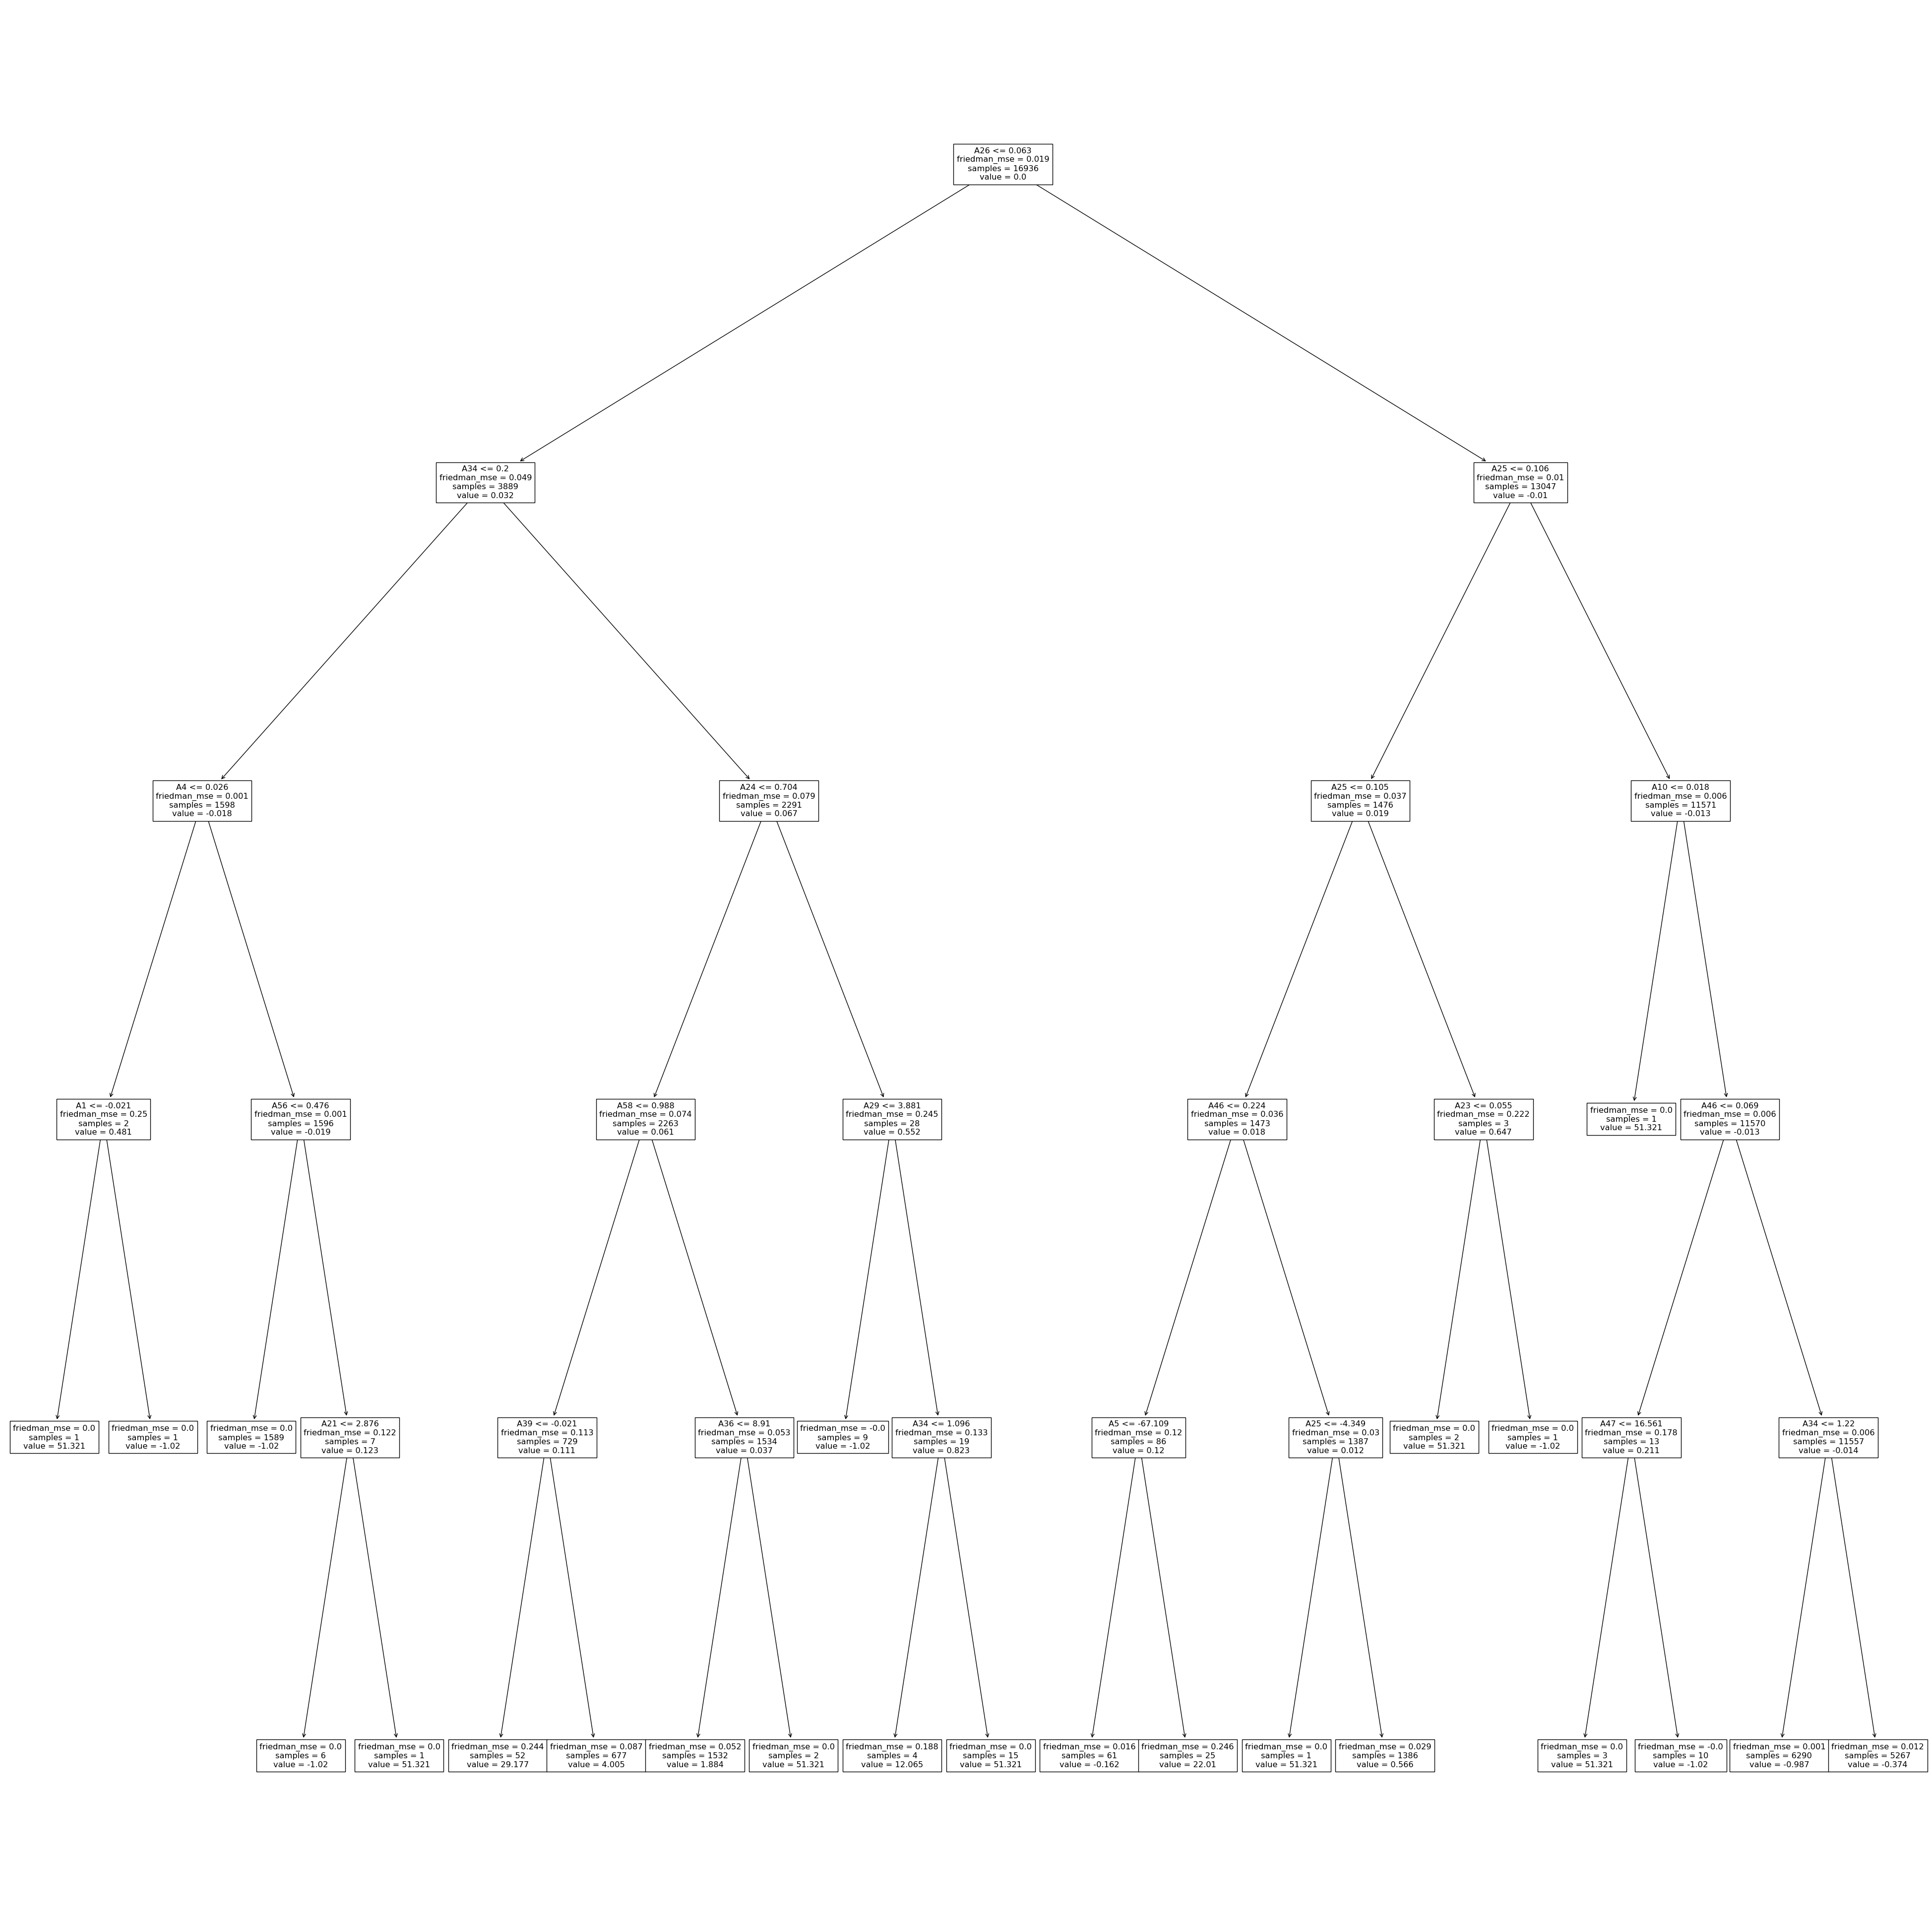

In [49]:
single_tree = best_clf.estimators_[0, 0]

fig, ax = plt.subplots(figsize=(50, 50)) 
plot_tree(single_tree, feature_names=feature_names, ax=ax)
plt.show()